In [1]:
import zipfile
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from PIL import Image
import tensorflow_addons as tfa
import numpy as np
import shutil
import random
from sklearn.metrics import classification_report

d:\miniconda\envs\GPUBRO\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\miniconda\envs\GPUBRO\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [2]:
random.seed(123)

In [3]:
# Ruta al directorio que contiene las carpetas de aves
data_directory = r'C:\Users\matia\OneDrive\Escritorio\pajaros\PROYECTO'
# Lista de categorías que deseas incluir
included_categories = ['comrav', 'bncfly', 'eursta', 'gbwwre1', 'houspa', 'houwre', 'norcar', 'redcro', 'sonspa', 'spotow']
# Crear directorios para las categorías seleccionadas y seleccionar imágenes
selected_directory = r'C:\Users\matia\OneDrive\Escritorio\pajaros\selected_aves'
os.makedirs(selected_directory, exist_ok=True)

In [4]:
import os
from PIL import Image
import numpy as np

base_dir = r'C:\Users\matia\OneDrive\Escritorio\pajaros\selected_aves'

In [5]:
image_paths = []
labels = []
label_map = {}

for bird_folder in os.listdir(base_dir):
    bird_dir = os.path.join(base_dir, bird_folder)
    if os.path.isdir(bird_dir):
        # Crear un label map
        if bird_folder not in label_map:
            label_map[bird_folder] = len(label_map)
        label = label_map[bird_folder]
        for file in os.listdir(bird_dir):
            if file.endswith('.png'):
                img_path = os.path.join(bird_dir, file)
                image_paths.append(img_path)
                labels.append(label)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)

In [6]:
# Crear un generador de datos
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, dim=(224, 224), n_channels=3, n_classes=10, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_paths_temp, labels_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, labels_temp):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, (img_path, label) in enumerate(zip(image_paths_temp, labels_temp)):
            img = Image.open(img_path)
            img = img.resize(self.dim)
            img_array = np.array(img)
            if img_array.shape == (224, 224, 4):  # En caso de tener canal alfa
                img_array = img_array[..., :3]  # Remover el canal alfa
            X[i,] = img_array / 255.0  # Normalizar

            y[i] = label

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)


In [7]:
from PIL import Image
import numpy as np
import os

# Ruta a la imagen que deseas revisar
img_path = 'selected_aves/bncfly/XC2646_segment_2.png'  # Reemplaza 'ruta/a/la/imagen.png' con la ruta de una imagen específica

# Verificar si la imagen existe
if os.path.exists(img_path):
    # Abrir la imagen
    img = Image.open(img_path)
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Imprimir detalles de la imagen y su array numpy
    print(f"Formato: {img.format}")
    print(f"Tamaño: {img.size}")
    print(f"Modo: {img.mode}")
    print(f"Valores mínimos del array: {img_array.min()}")
    print(f"Valores máximos del array: {img_array.max()}")
    print(f"Tipo de datos del array: {img_array.dtype}")
else:
    print(f"La imagen en {img_path} no existe.")

Formato: PNG
Tamaño: (224, 224)
Modo: RGB
Valores mínimos del array: 0
Valores máximos del array: 255
Tipo de datos del array: uint8


In [8]:
# Parámetros
batch_size = 32
epochs = 10
n_classes = len(label_map)
train_generator = DataGenerator(train_paths, train_labels, batch_size=batch_size, n_classes=n_classes)
val_generator = DataGenerator(val_paths, val_labels, batch_size=batch_size, n_classes=n_classes)
test_generator = DataGenerator(test_paths, test_labels, batch_size=batch_size, n_classes=n_classes, shuffle=False)


In [9]:
# Crear la arquitectura de ResNet50 sin pesos preentrenados
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compilar el modelo con métricas adicionales
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tfa.metrics.F1Score(num_classes=n_classes, average='weighted'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_model_h5.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1)


In [11]:
# Entrenar el modelo
history = model.fit(train_generator, 
          epochs=epochs, 
          validation_data=val_generator, 
          callbacks=[checkpoint, early_stopping])


Epoch 1/10
853/853 [==============================] - ETA: 0s - loss: 2.0072 - accuracy: 0.3035 - f1_score: 0.2937 - precision: 0.7094 - recall: 0.1164
Epoch 1: val_accuracy improved from -inf to 0.51023, saving model to best_model_h5.keras
853/853 [==============================] - 212s 203ms/step - loss: 2.0072 - accuracy: 0.3035 - f1_score: 0.2937 - precision: 0.7094 - recall: 0.1164 - val_loss: 1.4558 - val_accuracy: 0.5102 - val_f1_score: 0.4903 - val_precision: 0.7352 - val_recall: 0.3342
Epoch 2/10
853/853 [==============================] - ETA: 0s - loss: 1.2478 - accuracy: 0.5839 - f1_score: 0.5823 - precision: 0.7756 - recall: 0.4183
Epoch 2: val_accuracy did not improve from 0.51023
853/853 [==============================] - 175s 205ms/step - loss: 1.2478 - accuracy: 0.5839 - f1_score: 0.5823 - precision: 0.7756 - recall: 0.4183 - val_loss: 2.0397 - val_accuracy: 0.4110 - val_f1_score: 0.3924 - val_precision: 0.4766 - val_recall: 0.3513
Epoch 3/10
853/853 [==================

In [15]:
# Evaluar el modelo en el conjunto de prueba
test_metrics = model.evaluate(test_generator)
print(f"Test Accuracy: {test_metrics[1]}")
print(f"Test F1 Score: {test_metrics[2]}")
print(f"Test Precision: {test_metrics[3]}")
print(f"Test Recall: {test_metrics[4]}")

284/284 [==============================] - 33s 116ms/step - loss: 0.5507 - accuracy: 0.8253 - f1_score: 0.8253 - precision: 0.8795 - recall: 0.7858
Test Accuracy: 0.8252640962600708
Test F1 Score: 0.8253258466720581
Test Precision: 0.87954181432724
Test Recall: 0.7857614159584045


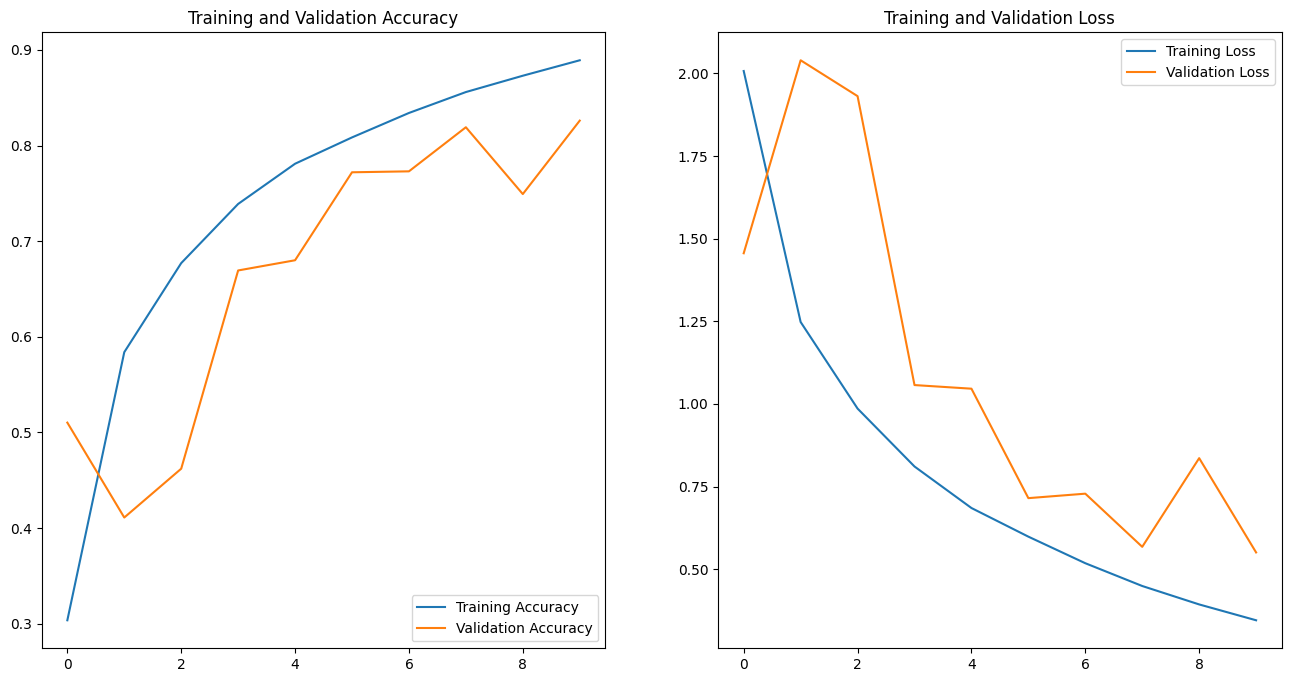

In [13]:
import matplotlib.pyplot as plt

# Guardar el historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Graficar precisión y pérdida
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
